In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # Mat Graphs
import seaborn as sns # Other graphs
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk #Modeling
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/deathscovid19andtemp/COVID19vsTemp.csv


This dataset has informaton regarding Temperatures and Type of climates. The data is grouped by EEUU and Argentina States. The plan is to explore the data, and evaluate if there are any relationships between temperature, climate types, and incidence of elderly death by pneumonia and COVID19.


**The data dictionary of this dataset:**
* StName: Is the name of the State.
* AvgTemCelsius: Is the average temperature in celcius of the major cities of the state.
* KoppenClimType: Is the climate Type of the major cities, using the koppen climate classification (https://en.wikipedia.org/wiki/K%C3%B6ppen_climate_classification)
* DeathsPer100kHabs: Deaths produced by COVID19 per 100k habitants.
* DeathsPer1k70plusHabs: Deaths produced by COVID19 per 1k habitants with age over 70.
* Country: Country of the state

**¿Why using Argentina and United States?**

As you will see in the dataset, both countries have a wide range of climates and average temperatures that goes from 2C to 23C, and they have a decent COVID19 death data registration.

First of all, we will load the CSV, and see the structure of the data.

In [2]:
df = pd.read_csv("../input/deathscovid19andtemp/COVID19vsTemp.csv")
df.head()

,StName,AvgTempCelsius,TotPop,KoppenClimType,DeathsPer100khabs,DeathsPer1k70plusHabs,Country
0,Buenos Aires,17.0,17541141,cfa,375.66,31.9,Argentina
1,CABA,17.0,3075646,cfa,463.67,27.9,Argentina
2,Catamarca,16.0,415438,BWk,144.19,12.6,Argentina
3,Chaco,21.5,1204541,cfa,228.72,20.5,Argentina
4,Chubut,12.8,618994,BSk,257.35,35.3,Argentina


In [3]:
#Lets see some info about the numeric data in the DataFrame
df.describe()

,AvgTempCelsius,TotPop,DeathsPer100khabs,DeathsPer1k70plusHabs
count,75.000000,7.500000e+01,75.000000,75.000000
mean,14.253333,5.024347e+06,224.275600,56.144133
std,4.694083,6.746765e+06,77.191327,34.974980
min,2.000000,1.734320e+05,59.000000,6.120000
25%,10.800000,9.841305e+05,171.000000,27.400000
50%,14.400000,2.961279e+06,228.720000,55.930000
75%,17.200000,6.166068e+06,275.500000,77.905000
max,23.200000,3.953822e+07,463.670000,211.840000


In [4]:
#It would be intresting se the distribution and correlations between aspects of the dataset.
#It's important first to encode the Koppen climate types, and other categorical values.
#First lets see the cardinality of this column.
df["KoppenClimType"] = df["KoppenClimType"].str.lower()
print(df["KoppenClimType"].unique())


['cfa' 'bwk' 'bsk' 'cfb' 'cwa' 'et' 'dfb' 'bwh' 'csa' 'dfa' 'af' 'csb'
 'dsa']


In [5]:
#First of all, lets see the pure correlations between variables. 
#To do this, we will Ordinal Encode the KoppenClimType column only

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
OHC = OneHotEncoder(handle_unknown='ignore', sparse=False)
ORD = OrdinalEncoder()
Cols_names = df.columns

Corr_Ordinal_Columns= ["KoppenClimType"]
CorrDF = df

CorrDF[Corr_Ordinal_Columns] = pd.DataFrame(ORD.fit_transform(df[Corr_Ordinal_Columns]))
print("Ordinal encoded columns")
CorrDF.columns = Cols_names
print(CorrDF.head())


Ordinal encoded columns
         StName  AvgTempCelsius    TotPop  KoppenClimType  DeathsPer100khabs  \
0  Buenos Aires            17.0  17541141             4.0             375.66   
1          CABA            17.0   3075646             4.0             463.67   
2     Catamarca            16.0    415438             3.0             144.19   
3         Chaco            21.5   1204541             4.0             228.72   
4        Chubut            12.8    618994             1.0             257.35   

   DeathsPer1k70plusHabs    Country  
0                   31.9  Argentina  
1                   27.9  Argentina  
2                   12.6  Argentina  
3                   20.5  Argentina  
4                   35.3  Argentina  


<AxesSubplot:>

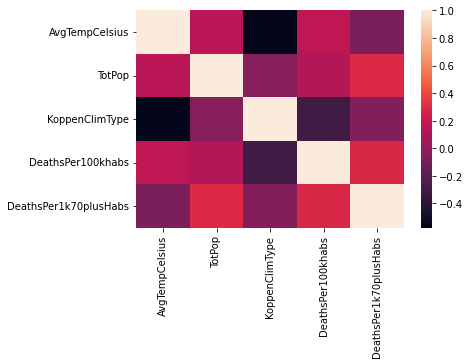

In [6]:
#["AvgTempCelsius","TotPop","KoppenClimType","DeathsPer100khabs","DeathsPer1k70plusHabs"]
#corr = df['AvgTempCelsius','TotPop','KoppenClimType','DeathsPer100khabs','DeathsPer1k70plusHabs'].corr()
corr =CorrDF.corr()
sns.heatmap(corr, 
        xticklabels=['AvgTempCelsius','TotPop','KoppenClimType','DeathsPer100khabs','DeathsPer1k70plusHabs'],
        yticklabels=['AvgTempCelsius','TotPop','KoppenClimType','DeathsPer100khabs','DeathsPer1k70plusHabs'])

At a first glance we encounter low correlations between the different columns in the dataframe. We will try different approachs to find if we have any reationship between variables put together in a decision tree.

<AxesSubplot:xlabel='DeathsPer1k70plusHabs', ylabel='AvgTempCelsius'>

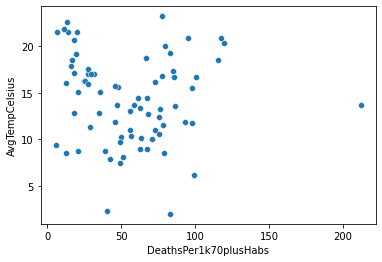

In [7]:
sns.scatterplot(data=CorrDF, x="DeathsPer1k70plusHabs", y="AvgTempCelsius")

As a first glance, it seems that there is no correlacion here. It's a cloud, with some outlayers. Let's see if we put some color for each country, we have any better understanding of the data.

<AxesSubplot:xlabel='DeathsPer1k70plusHabs', ylabel='AvgTempCelsius'>

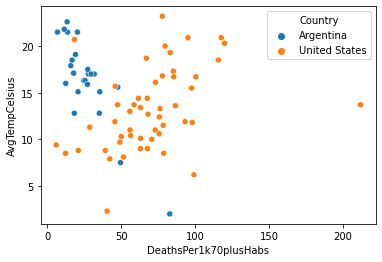

In [8]:
sns.scatterplot(data=CorrDF, x="DeathsPer1k70plusHabs", y="AvgTempCelsius",hue='Country')

We have some hope here. It seems that each country have any sligth form of correlation with COVID19 elder deaths and Avg temperature. Let's see the overall deaths (Measured per 100k of habitants)

<AxesSubplot:xlabel='DeathsPer100khabs', ylabel='AvgTempCelsius'>

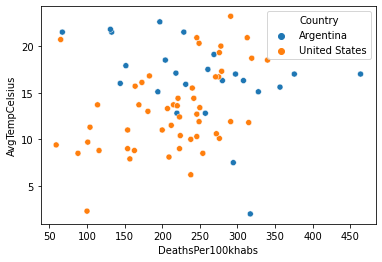

In [9]:
sns.scatterplot(data=CorrDF, x="DeathsPer100khabs", y="AvgTempCelsius",hue='Country')

In this case, we have no correlation at all. The dots are mixed up enough to avoid any analysis.

<AxesSubplot:xlabel='DeathsPer100khabs', ylabel='AvgTempCelsius'>

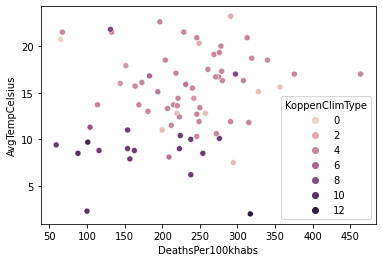

In [10]:
sns.scatterplot(data=CorrDF, x="DeathsPer100khabs", y="AvgTempCelsius",hue='KoppenClimType')

Now, we will preprocess the dataset for different ML aproaches, in order to predict data regarding deaths.

In [11]:
#We will try different approaches to encode this column, and the country and State column#s
#First we will make an ordinal encode.

Ordinal_Columns= ['StName']
OH_Columns= ['KoppenClimType','Country']


df[Ordinal_Columns] = pd.DataFrame(ORD.fit_transform(df[Ordinal_Columns]))
df.columns = Cols_names

OH_NCols = pd.DataFrame(OHC.fit_transform(df[OH_Columns]))
OH_NCols.index = df.index
df = df.drop(OH_Columns, axis=1)


FinalDataSet = pd.concat([df,OH_NCols], axis=1)


FinalDataSet.head()


,StName,AvgTempCelsius,TotPop,DeathsPer100khabs,DeathsPer1k70plusHabs,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,4.0,17.0,17541141,375.66,31.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5.0,17.0,3075646,463.67,27.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7.0,16.0,415438,144.19,12.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,8.0,21.5,1204541,228.72,20.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9.0,12.8,618994,257.35,35.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
from sklearn.model_selection import train_test_split
#In this case, i will spare 2 variables for further prediction.
#They are bonded, so putting one of them as predictor, will result in a poor model.

y1=FinalDataSet.DeathsPer1k70plusHabs
y2=FinalDataSet.DeathsPer100khabs
FinalDataSet.drop('DeathsPer1k70plusHabs',axis=1,inplace=True)
FinalDataSet.drop('DeathsPer100khabs',axis=1,inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(FinalDataSet, y1,
                                                      train_size=0.9, test_size=0.1,
                                                      random_state=0)

In [13]:
#In order to evaluate differents approaches, i will create a function to score each one of the predictions,
#using MAE (Mean Absolute Error)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def score_datasetRF(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [14]:
print('MAE of predictions regarding elder deaths:')
print(score_datasetRF(X_train, X_valid, y_train, y_valid))

MAE of predictions regarding elder deaths:
22.31888750000001


In [15]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(FinalDataSet, y2,
                                                      train_size=0.9, test_size=0.1,
                                                      random_state=0)

In [16]:
print('MAE of predictions regarding ovearll deaths:')
print(score_datasetRF(X_train2, X_valid2, y_train2, y_valid2))

MAE of predictions regarding ovearll deaths:
71.59209999999999


The MAE of the prediction of the first variable is 22.3, whereas the Standard deviation we saw in the first step was ~35.

The MAE of second variable prediction is 71.6, and the standard deviation in the dataset for this variable is 77.2. Not a good precision of the prediction.

Let's visualize the errors, and their shape.

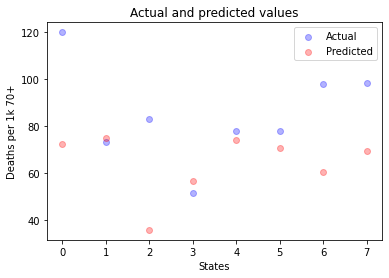

In [17]:


model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_valid)

_, ax = plt.subplots()

ax.scatter(x = range(0, y_valid.size), y=y_valid, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, preds.size), y=preds, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('States')
plt.ylabel('Deaths per 1k 70+')
plt.legend()
plt.show()
